# Imports

In [1]:
from datetime import timedelta
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

from icedef import iceberg, metocean, drift_simulation, plot
from icedef.turnbull import drift

# Iceberg

In [4]:
df = pd.read_csv('csvs/0204980_2015.csv')

In [5]:
df['DataDate_UTC'] = pd.to_datetime(df['DataDate_UTC'])

In [6]:
times = [t.to_pydatetime() for t in df['DataDate_UTC']]

In [8]:
lons = df['Longitude']

In [9]:
lats = df['Latitude']

In [10]:
ref_berg = iceberg.Iceberg('0204980_2015', times[0], lons[0], lats[0], 0, 0, 0, 0, 'LG', 'TAB')

In [67]:
ref_berg.history['T'] = times[:1000]
ref_berg.history['X'] = lons[:1000]
ref_berg.history['Y'] = lats[:1000]

In [68]:
berg = iceberg.clone_iceberg_state(ref_berg)

# Metocean

In [69]:
ocean_data = metocean.ECMWFOcean(ref_berg.history['T'][0], ref_berg.history['T'][-1])

#ocean_data.filenames

In [70]:
atm_data = metocean.NARRAtm(ref_berg.history['T'][0], ref_berg.history['T'][-1])

#atm_data.filenames

# Drift Simulation

In [71]:
sim = drift_simulation.DriftSimulation(berg, ocean_data, atm_data, drift)

In [72]:
dt = 0.1*3600
t0 = ref_berg.history['T'][0]
tf = ref_berg.history['T'][-1]
tdelta = tf - t0
tdelta_secs = tdelta.days*12*3600 + tdelta.seconds
nt = int(tdelta_secs//dt)

In [73]:
#sim.euler(dt,nt)
sim.rk2(dt, nt)

In [74]:
sim.history.head()

,t,vax,vay,vcx,vcy,vx,vy,x,y
0,2015-04-24 15:16:06,-3.217008,-0.978001,0.043383,0.073384,0.000000,0.000000,-51.551440,51.459910
1,2015-04-24 15:22:06,-3.243216,-0.949190,0.043929,0.072737,-0.002218,0.003565,-51.551452,51.459922
2,2015-04-24 15:28:06,-3.269427,-0.920377,0.044472,0.072088,-0.004213,0.006780,-51.551473,51.459943
3,2015-04-24 15:34:06,-3.295639,-0.891564,0.044688,0.071257,-0.006009,0.009689,-51.551505,51.459975
4,2015-04-24 15:40:06,-3.321854,-0.862750,0.044751,0.070342,-0.007651,0.012316,-51.551544,51.460015


# Plot

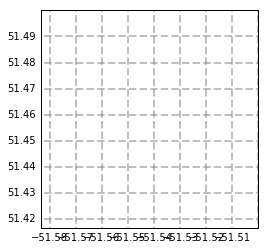

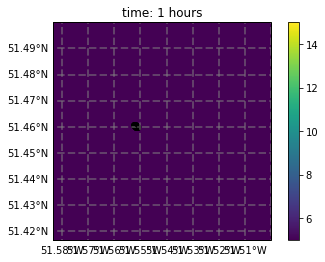

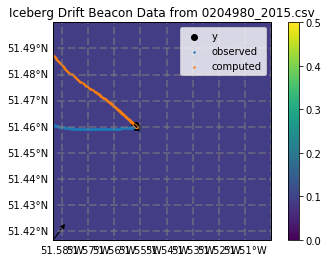

In [75]:
plt.scatter(ref_berg.history['X'], ref_berg.history['Y'], s=2, label='observed')
plt.scatter(sim.history['x'], sim.history['y'], s=2, label='computed')
plt.title('Iceberg Drift Beacon Data from 0204980_2015.csv')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

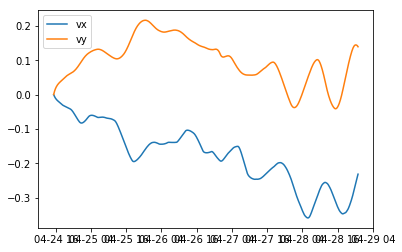

In [76]:
plt.plot(sim.history['t'], sim.history['vx'], label='vx')
plt.plot(sim.history['t'], sim.history['vy'], label='vy')
plt.legend()
plt.show()

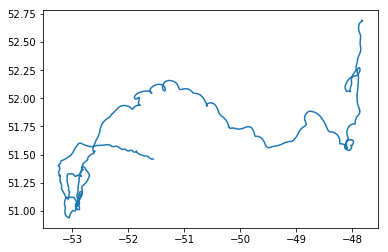

In [77]:
plt.plot(df['Longitude'], df['Latitude'])
plt.show()

In [78]:
from mpl_toolkits.basemap import Basemap
from matplotlib.animation import FuncAnimation

In [79]:
def animate_currents(ocean_data, iip_berg, mod_berg):
    """This function saves a gif of the ocean current velocities alongside an iceberg drift test case.
    
    Args:
        ocean_data (ECMWF_Ocean): ocean data for time and space of iceberg drift simulation.
        iip_berg (Iceberg): all attributes correspond to data from a particular IIP iceberg.
        mod_berg (Iceberg): initial attributes and final time correspond to data from a particular 
                            IIP iceberg but the rest comes from drift simulation.
    """
    
    
    mod_berg_t1950 = nc.date2num(mod_berg.datetimes, 
                                 'hours since 1950-01-01 00:00:00.0 00:00', 'standard')
    
    lon0 = np.where(ocean_data.lons < min(mod_berg.lons))[0][-1]
    lonn = np.where(ocean_data.lons > max(mod_berg.lons))[0][0]
    lat0 = np.where(ocean_data.lats < min(mod_berg.lats))[0][-1] 
    latn = np.where(ocean_data.lats > max(mod_berg.lats))[0][0]
    
    UW = np.empty([len(mod_berg_t1950), 
                len(ocean_data.lats[lat0-1:latn+1]), len(ocean_data.lons[lon0-1:lonn+1])])
    VW = np.empty([len(mod_berg_t1950), 
                len(ocean_data.lats[lat0-1:latn+1]), len(ocean_data.lons[lon0-1:lonn+1])])
    
    for i, ival in enumerate(mod_berg_t1950):
        for j, jval in enumerate(ocean_data.lats[lat0-1:latn+1]):
            for k, kval in enumerate(ocean_data.lons[lon0-1:lonn+1]):
                UW[i][j][k] = ocean_data.iUW([ival,jval,kval])
                VW[i][j][k] = ocean_data.iVW([ival,jval,kval])
    
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([ocean_data.lons[lon0], ocean_data.lons[lonn], ocean_data.lats[lat0], ocean_data.lats[latn]], ccrs.PlateCarree())
    #ax.stock_img()
    ax.coastlines('50m')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax.scatter(iip_berg.lons[:], iip_berg.lats[:], color='black')
    #ax.plot(mod_berg.lons[:], mod_berg.lats[:], color='black')
    water_mag = np.sqrt(UW**2 + VW**2)
    im = plt.imshow(water_mag[0,:,:], 
                    extent=[ocean_data.lons[lon0-1], ocean_data.lons[lonn+1], 
                            ocean_data.lats[lat0-1], ocean_data.lats[latn+1]],
                    origin = 'lower', vmin=0, vmax=0.5)
    
    line, = plt.plot(mod_berg.lons[0], mod_berg.lats[0], color='black')
    
    plt.colorbar()
    quiv = plt.quiver(ocean_data.lons[lon0-1:lonn+1], ocean_data.lats[lat0-1:latn+1], UW[0,:,:], VW[0,:,:], 
                      scale=1, headwidth=5, width=0.005)
    title = plt.title('time: 0 hours')


    def animate(i):

        im.set_data(water_mag[i,:,:])
        quiv.set_UVC(UW[i,:,:], VW[i,:,:])
        title.set_text('time: {:.0f} hours'.format(mod_berg_t1950[i]-mod_berg_t1950[0]))
        line.set_data(mod_berg.lons[0:i+1], mod_berg.lats[0:i+1])
        
        
        return im, line
    
    anim = FuncAnimation(fig, animate, frames=water_mag[:,0,0].size-1, interval=100)
    #HTML(anim.to_html5_video())
    anim.save('plots/water_mag.gif',writer='imagemagick')
        
    
    
def animate_winds(atm_data, iip_berg, mod_berg):
    """This function saves a gif of the wind velocities alongside an iceberg drift test case.
    
    Args:
        atm_data (ECMWF_Atm): atmospheric data for time and space of iceberg drift simulation.
        iip_berg (Iceberg): all attributes correspond to data from a particular IIP iceberg.
        mod_berg (Iceberg): initial attributes and final time correspond to data from a particular 
                            IIP iceberg but the rest comes from drift simulation.
    """
    
    mod_berg_t1900 = nc.date2num(mod_berg.datetimes, 
                                 'hours since 1900-01-01 00:00:00.0 00:00', 'standard')
    
    lon0 = np.where(atm_data.lons < min(mod_berg.lons))[0][-1]
    lonn = np.where(atm_data.lons > max(mod_berg.lons))[0][0]
    lat0 = np.where(atm_data.lats < min(mod_berg.lats))[0][-1] 
    latn = np.where(atm_data.lats > max(mod_berg.lats))[0][0]
    
    UA = np.empty([len(mod_berg_t1900), 
                len(atm_data.lats[lat0-1:latn+1]), len(atm_data.lons[lon0-1:lonn+1])])
    VA = np.empty([len(mod_berg_t1900), 
                len(atm_data.lats[lat0-1:latn+1]), len(atm_data.lons[lon0-1:lonn+1])])
    
    for i, ival in enumerate(mod_berg_t1900):
        for j, jval in enumerate(atm_data.lats[lat0-1:latn+1]):
            for k, kval in enumerate(atm_data.lons[lon0-1:lonn+1]):
                UA[i][j][k] = atm_data.iUA([ival,jval,kval])
                VA[i][j][k] = atm_data.iVA([ival,jval,kval])
    
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([atm_data.lons[lon0], atm_data.lons[lonn], atm_data.lats[lat0], atm_data.lats[latn]], ccrs.PlateCarree())
    #ax.stock_img()
    ax.coastlines('50m')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax.scatter(iip_berg.lons[:], iip_berg.lats[:], color='black')
    wind_mag = np.sqrt(UA**2 + VA**2)
    im = plt.imshow(wind_mag[0,:,:], 
                    extent=[atm_data.lons[lon0-1], atm_data.lons[lonn+1], 
                            atm_data.lats[lat0-1], atm_data.lats[latn+1]],
                    origin = 'lower', vmin=5, vmax=15)
    
    line, = plt.plot(mod_berg.lons[0], mod_berg.lats[0], color='black')
    
    plt.colorbar()
    quiv = plt.quiver(atm_data.lons[lon0-1:lonn+1], atm_data.lats[lat0-1:latn+1], UA[0,:,:], VA[0,:,:], 
                      scale=20, headwidth=5, width=0.005)
    title = plt.title('time: 0 hours')


    def animate(i):

        im.set_data(wind_mag[i,:,:])
        quiv.set_UVC(UA[i,:,:], VA[i,:,:])
        title.set_text('time: {:.0f} hours'.format(mod_berg_t1900[i]-mod_berg_t1900[0]))
        line.set_data(mod_berg.lons[0:i+1], mod_berg.lats[0:i+1])
        
        
        return im, line
    
    anim = FuncAnimation(fig, animate, frames=wind_mag[:,0,0].size-1, interval=100)
    #HTML(anim.to_html5_video())
    anim.save('plots/wind_mag.gif',writer='imagemagick')

In [80]:
from scipy.interpolate import RegularGridInterpolator as RGI

In [87]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [108]:
def metocean_animation(drift_track, data_grid, data, fname='field_anim',
                       vmin=0, vmax=1, scale=1, headwidth=5, width=5e-3):
    
    x_vec = drift_track[0]
    y_vec = drift_track[1]
    t_vec = drift_track[2]
    
    grid_t = data_grid[0]
    grid_y = data_grid[1]
    grid_x = data_grid[2]
    
    data_u = data[0]
    data_v = data[1]
    
    u_RGI = RGI((grid_t, grid_y, grid_x), data_u) 
    v_RGI = RGI((grid_t, grid_y, grid_x), data_v)
    
    lon0 = np.where(grid_x < min(x_vec))[0][-1]
    lonn = np.where(grid_x > max(x_vec))[0][0]
    lat0 = np.where(grid_y < min(y_vec))[0][-1] 
    latn = np.where(grid_y > max(y_vec))[0][0]
    
    u_mat = np.empty([len(t_vec), len(grid_y[lat0-1:latn+1]), len(grid_x[lon0-1:lonn+1])])
    v_mat = np.empty([len(t_vec), len(grid_y[lat0-1:latn+1]), len(grid_x[lon0-1:lonn+1])])
    
    for i, ival in enumerate(t_vec):
        for j, jval in enumerate(grid_y[lat0-1:latn+1]):
            for k, kval in enumerate(grid_x[lon0-1:lonn+1]):
                u_mat[i][j][k] = u_RGI([ival,jval,kval])
                v_mat[i][j][k] = v_RGI([ival,jval,kval])
                
    
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([grid_x[lon0], grid_x[lonn], grid_y[lat0], grid_y[latn]], 
                  ccrs.PlateCarree())
    
    #ax.stock_img()
    ax.coastlines('50m')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                      draw_labels=True,linewidth=2, color='gray', 
                      alpha=0.5, linestyle='--')
    
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    
    #ax.scatter(x_vec, y_vec, color='black')
    w_mat = np.sqrt(u_mat**2 + v_mat**2)
    im = plt.imshow(w_mat[0,:,:], 
                    extent=[grid_x[lon0-1], grid_x[lonn+1], 
                            grid_y[lat0-1], grid_y[latn+1]],
                    origin = 'lower', vmin=vmin, vmax=vmax)
    
    line, = plt.plot(x_vec[0], y_vec[0], color='black')
    
    plt.colorbar()
    
    quiv = plt.quiver(grid_x[lon0-1:lonn+1], grid_y[lat0-1:latn+1], 
                      u_mat[0,:,:], v_mat[0,:,:], 
                      scale=scale, headwidth=headwidth, width=width)
    
    title = plt.title('time: 0 hours')


    def animate(i):
        im.set_data(w_mat[i,:,:])
        quiv.set_UVC(u_mat[i,:,:], v_mat[i,:,:])
        title.set_text('time: {:.0f} hours'.format(t_vec[i]-t_vec[0]))
        line.set_data(x_vec[0:i+1], y_vec[0:i+1])
        return im, line
    
    
    anim = FuncAnimation(fig, animate, frames=w_mat[:,0,0].size-1, interval=100)
    #HTML(anim.to_html5_video())
    anim.save(f'plots/{fname}.gif',writer='imagemagick')
    

In [96]:
drift_track = [
                sim.history['x'][:400],
                sim.history['y'][:400],
                nc.date2num(sim.history['t'][:400], ocean_data.T_UNITS, 
                            ocean_data.T_CALENDAR)
]

data_grid = [
                ocean_data.times,
                ocean_data.lats,
                ocean_data.lons
]

data = [
                ocean_data.U,
                ocean_data.V
]

In [97]:
metocean_animation(drift_track, data_grid, data)

In [109]:
drift_track = [
                sim.history['x'][:400],
                sim.history['y'][:400],
                nc.date2num(sim.history['t'][:400], atm_data.T_UNITS, 
                            atm_data.T_CALENDAR)
]

data_grid = [
                atm_data.times,
                atm_data.lats,
                atm_data.lons
]

data = [
                atm_data.U,
                atm_data.V
]

In [110]:
metocean_animation(drift_track, data_grid, data, fname='wind_anim', 
                   vmin=0, vmax=15, scale=20)